**1. Transfer-Matrix Simulation of a 10-Period TiO₂/SiO₂ Dielectric Bragg Mirror.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

λ₀ is the target center wavelength (633 nm).

In [ ]:
lambda0   = 633e-9     # design wavelength (m)
n_air     = 1.0        # refractive index of surrounding medium (air)
n_silica  = 1.45       # refractive index of SiO₂ (low‐index layer)
n_titania = 2.07       # refractive index of TiO₂ (high‐index layer)
periods   = 10         # number of TiO₂/SiO₂ bilayers

For maximum reflectance at λ₀, each layer’s optical thickness satisfies $𝑛 𝑑 =𝜆_0/4$.



In [ ]:
d_silica  = lambda0 / (4 * n_silica)
d_titania = lambda0 / (4 * n_titania)

$ns$ is the list of refractive indices of each layer, including the incident and exit media (air). $ds$ is the list of physical thicknesses (zero for semi‐infinite media).

In [ ]:
# Sequence: Air | (TiO₂ / SiO₂) × periods | Air
ns = [n_air] + [val for _ in range(periods) for val in (n_titania, n_silica)] + [n_air]
ds = [0]     + [val for _ in range(periods) for val in (d_titania, d_silica)] + [0]

Mᵢ relates the fields (E, H) at the front interface to those at the back of layer i.

In [ ]:
def layer_matrix(n, d, wavelength):

    #Returns the 2×2 characteristic matrix of a homogeneous layer.

    k0    = 2 * np.pi / wavelength           # free‐space wavenumber
    delta = n * k0 * d                        # phase thickness
    Y     = n                                 # wave admittance in non‐magnetic media

    return np.array([
        [ np.cos(delta),       1j * np.sin(delta) / Y ],
        [ 1j * Y * np.sin(delta), np.cos(delta)     ]
    ], dtype=complex)


Sequentially multiplies each layer’s matrix to get the net 2×2 matrix M for the entire stack

In [ ]:
def stack_matrix(ns, ds, wavelength):

    #Multiplies together the layer matrices of all internal films.

    M = np.eye(2, dtype=complex)         # start with identity
    # skip the first and last, which are semi‐infinite media
    for n, d in zip(ns[1:-1], ds[1:-1]):
        M = M @ layer_matrix(n, d, wavelength)
    return M


Implements the boundary‐condition matching at the first/last interface to extract r and t.

In [ ]:
def reflect_transmit(ns, ds, wavelength):

    #Computes R and T for the stack at a given wavelength.

    Y0 = ns[0]      # admittance of incident medium (air)
    Ys = ns[-1]     # admittance of exit medium (air)
    M  = stack_matrix(ns, ds, wavelength)
    M11, M12, M21, M22 = M.flat

    # reflection and transmission coefficients:
    num =   Y0*M11 + Y0*Ys*M12 - M21 - Ys*M22
    den =   Y0*M11 + Y0*Ys*M12 + M21 + Ys*M22
    r   = num / den
    t   = (2 * Y0) / den

    # Power reflectance & transmittance
    R = np.abs(r)**2
    T = np.abs(t)**2 * (Ys / Y0)   # here Ys=Y0, so T = |t|^2

    return R, T


Builds arrays of $R(λ)$ and $T(λ)$

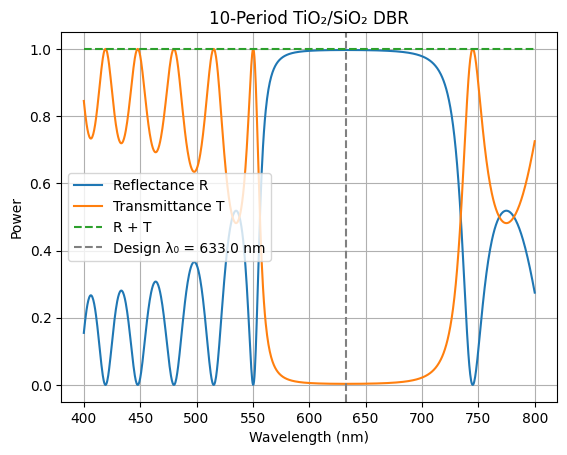

In [ ]:
wavelengths = np.linspace(400e-9, 800e-9, 1000) #Samples 1,000 wavelengths between 400 nm and 800 nm.
Rs, Ts      = zip(*(reflect_transmit(ns, ds, wl) for wl in wavelengths))
Rs, Ts      = np.array(Rs), np.array(Ts)
plt.figure()
plt.plot(wavelengths * 1e9, Rs, label='Reflectance R')
plt.plot(wavelengths * 1e9, Ts, label='Transmittance T')
plt.plot(wavelengths * 1e9, Rs + Ts, '--', label='R + T')

plt.axvline(lambda0 * 1e9,
            linestyle='--',
            color='gray',
            label=f"Design λ₀ = {lambda0*1e9:.1f} nm")

plt.xlabel('Wavelength (nm)')
plt.ylabel('Power')
plt.title('10-Period TiO₂/SiO₂ DBR')
plt.legend()
plt.grid(True)
plt.show()


**Inference:** This code models a stack of 10 alternating TiO₂/SiO₂ layers to see how much light it reflects and transmits between 400 nm and 800 nm. It uses the transfer-matrix method, treating each layer as a quarter of the design wavelength (633 nm) in thickness so that all reflections add up in phase at that color. The resulting plot shows a strong reflection peak (over 99%) at 633 nm and confirms that reflectance plus transmittance stays at 100%, meaning no energy is lost.

**2. Free-Space Wavenumber Analysis of a Quarter-Wave SiO₂/TiO₂ Bragg Mirror.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

These set the target wavelength, material indices, and stack size.

In [ ]:
lambda0   = 633e-9     # design wavelength in vacuum (m),(633 nm visible light)
n_air     = 1.0        # refractive index of surrounding medium (air)
n_silica  = 1.45       # refractive index of SiO₂ (low-index layer)
n_titania = 2.07       # refractive index of TiO₂ (high-index layer)
periods   = 10         # number of alternating SiO₂/TiO₂ quarter-wave pairs

Computes each layer’s optical thickness = $λ₀/4$ in that material. This makes the stack a distributed Bragg reflector (DBR) centered at $λ₀$.

In [ ]:
# Calculate optimal layer thicknesses for Bragg condition (λ0/4n)
d_silica  = lambda0 / (4 * n_silica)   # ~109 nm thick SiO₂ layers
d_titania = lambda0 / (4 * n_titania)  # ~76 nm thick TiO₂ layers

$ns$ refractive indices of each layer, including semi-infinite input/output air. $ds$ thickness of each layer (zero for the air regions).

In [ ]:
# Build index list: Air | (SiO₂, TiO₂) repeated | Air
ns = [n_air] + [val for _ in range(periods) for val in (n_silica, n_titania)] + [n_air]
# Corresponding physical thicknesses (zero for the two semi-infinite air “layers”)
ds = [0] + [val for _ in range(periods) for val in (d_silica, d_titania)] + [0]

Implements the standard 2×2 transfer-matrix for a single dielectric slab of index n and thickness $d$.

In [ ]:
def layer_matrix(n, d, wavelength):
    k0 = 2 * np.pi / wavelength             # free-space wavenumber
    delta = n * k0 * d                       # phase thickness of this layer
    Y = n                                    # wave admittance in normal incidence
    # 2×2 characteristic matrix for this layer
    return np.array([
        [ np.cos(delta),         1j * np.sin(delta) / Y ],
        [ 1j * Y * np.sin(delta),    np.cos(delta)    ]
    ])

All quarter-wave layers to get the net transfer matrix of the entire DBR.



In [ ]:
def stack_matrix(ns, ds, wavelength):
    #Calculate total matrix for multilayer stack
    M = np.eye(2, dtype=complex)            # Identity matrix initialization
    # multiply in each dielectric layer’s matrix (skip the first/last air)
    for n, d in zip(ns[1:-1], ds[1:-1]):
        M = M @ layer_matrix(n, d, wavelength)
    return M

Extracts reflection (R) and transmission (T) from the total matrix.

In [ ]:
def reflect_transmit(ns, ds, wavelength):
  #Calculate reflectance (R) and transmittance (T)
    Y0 = ns[0]                              # First medium admittance (air)
    Ys = ns[-1]                             # Last medium admittance (air)
    M = stack_matrix(ns, ds, wavelength)   # full-stack matrix
    # Extract matrix components
    M11, M12 = M[0,0], M[0,1]
    M21, M22 = M[1,0], M[1,1]
    # Fresnel formulas via transfer-matrix elements (Calculate reflection/transmission coefficients)
    num =  Y0*M11 + Y0*Ys*M12 - M21 - Ys*M22
    den =  Y0*M11 + Y0*Ys*M12 + M21 + Ys*M22
    r = num / den
    t = (2 * Y0) / den
    # Convert to power ratios
    R = np.abs(r)**2                       # reflected power
    T = np.abs(t)**2 * (Ys / Y0)          # transmitted power
    return R, T

Builds the spectra arrays $Rs$ and $Ts$ , then transforms wavelengths into wavenumbers for plotting.

In [ ]:
# Sweep from 700 nm to 1400 nm in 500 steps (near-IR range)
wavelengths = np.linspace(700e-9, 1400e-9, 500)
# Compute R and T at each wavelength
Rs, Ts = zip(*(reflect_transmit(ns, ds, wl) for wl in wavelengths))
Rs, Ts = np.array(Rs), np.array(Ts)

# Convert λ sweep into free-space wavenumber k₀
k0s       = 2 * np.pi / wavelengths
k0_design = 2 * np.pi / lambda0          # vertical line on the plot


Creates a clear plot of R and T as functions of k₀, highlighting the design point.



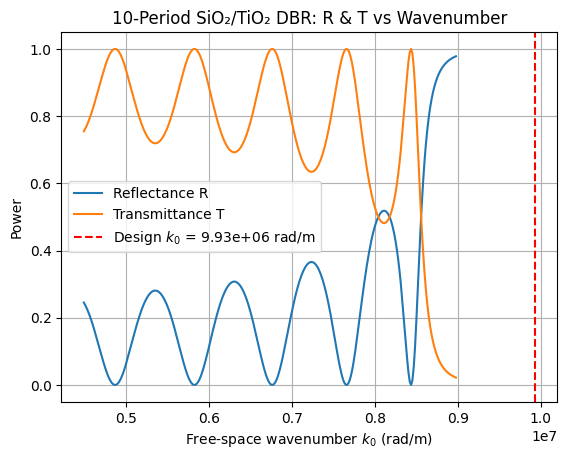

In [ ]:
plt.figure()
plt.plot(k0s, Rs, label='Reflectance R')         # R vs k₀
plt.plot(k0s, Ts, label='Transmittance T')       # T vs k₀
# Mark design wavenumber
plt.axvline(
    k0_design,
    linestyle='--',
    color='red',
    label=f"Design $k_0$ = {k0_design:.2e} rad/m"
)
plt.xlabel('Free-space wavenumber $k_0$ (rad/m)')
plt.ylabel('Power')
plt.title('10-Period SiO₂/TiO₂ DBR: R & T vs Wavenumber')
plt.legend()
plt.grid(True)
plt.show()

**Inference:** The simulated 10-period DBR exhibits a pronounced stopband (700–1400 nm) with >95% reflectance, demonstrating near-perfect reflection through constructive interference.  Correspondingly, the transmittance T falls nearly to zero at this wavelength, confirming a strong stop-band. Away from the stop-band edges, the stack becomes essentially transparent (low R, high T)

**3. 20-Period SiO₂/TiO₂ DBR: Reflectance & Transmittance vs Wavelength (Air–DBR–Air)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Defines the target wavelength and material indices for a 20-period dielectric stack.

In [ ]:
lambda0   = 633e-9     # Design wavelength (m),(visible red light)
n_air     = 1.0        # Refractive index of air (input/output medium)
n_silica  = 1.45       # Refractive index of SiO₂ (low-index layer)
n_titania = 2.07       # Refractive index of TiO₂ (high-index layer)
periods   = 20         # Number of alternating quarter-wave pairs

Computes each layer’s physical thickness so that its optical thickness equals $λ₀/4$.

In [ ]:
# Quarter-Wave Thickness Calculation
d_silica  = lambda0 / (4 * n_silica)  # SiO₂ layer thickness: ~109 nm
d_titania = lambda0 / (4 * n_titania) # TiO₂ layer thickness: ~76 nm

$ns$ holds refractive indices of each layer (including two air “half-spaces”).
$ds$ holds physical thicknesses (zero for the air regions).

In [ ]:
# Build layer index list Air | (SiO₂, TiO₂) × periods | Air
ns = [n_air] + [val for _ in range(periods) for val in (n_silica, n_titania)] + [n_air]
# Corresponding thicknesses (0 for the semi-infinite air layers)
ds = [0]+ [val for _ in range(periods) for val in (d_silica, d_titania)] + [0]

Returns the 2×2 characteristic matrix of a uniform dielectric slab.

In [ ]:
def layer_matrix(n, d, wavelength):
  # Calculate characteristic matrix for a single dielectric layer
    k0    = 2 * np.pi / wavelength  # Free-space wavenumber
    delta = n * k0 * d               # Phase accumulation in layer
    Y     = n                        # Wave admittance
    return np.array([
        [ np.cos(delta),        1j * np.sin(delta) / Y ],
        [ 1j * Y * np.sin(delta),    np.cos(delta)       ]
    ])

All individual layer matrices to form the net matrix of the entire DBR.

In [ ]:
def stack_matrix(ns, ds, wavelength):
  #Compute total transfer matrix for multilayer stack
    M = np.eye(2, dtype=complex)    # Identity matrix initialization
    # Multiply in each layer’s matrix (skip first/last which are air)
    for n, d in zip(ns[1:-1], ds[1:-1]):
        M = M @ layer_matrix(n, d, wavelength)
    return M

Calculates power reflectance $R$ and transmittance $T$ at a given wavelength.

In [ ]:
def reflect_transmit(ns, ds, wavelength):
  #Calculate reflectance (R) and transmittance (T) power coefficients
    Y0 = ns[0]                        # Input medium admittance (air)
    Ys = ns[-1]                       # Output admittance (air)
    M  = stack_matrix(ns, ds, wavelength)
   # Matrix element Component
    M11, M12 = M[0,0], M[0,1]
    M21, M22 = M[1,0], M[1,1]
    # Fresnel coefficients via transfer-matrix formalism
    num =  Y0*M11 + Y0*Ys*M12 - M21 - Ys*M22
    den =  Y0*M11 + Y0*Ys*M12 + M21 + Ys*M22
    r   = num / den                   # Reflection coefficient
    t   = (2 * Y0) / den              # Transmission coefficient
    R   = np.abs(r)**2                # Reflectance (power)
    T   = np.abs(t)**2 * (Ys / Y0)    # Transmittance (power, normalized)
    return R, T

Generates the $R/T$ spectra and confirms that $R+T≈1$(no loss).

In [ ]:
# Sweep from 400 nm to 800 nm in 1,000 steps
wavelengths = np.linspace(400e-9, 800e-9, 1000)
# Calculate R/T across wavelength range
Rs, Ts      = zip(*(reflect_transmit(ns, ds, wl) for wl in wavelengths))
Rs, Ts      = np.array(Rs), np.array(Ts)
total       = Rs + Ts # Energy conservation check

# Print min/max of R+T to verify energy conservation ≈1
print(f"Energy conservation: min(R+T) = {total.min():.6f}, max(R+T) = {total.max():.6f}")


Energy conservation: min(R+T) = 1.000000, max(R+T) = 1.000000


Plots $R$, $T$, and their sum vs. wavelength, with a vertical line at the design $λ₀$.

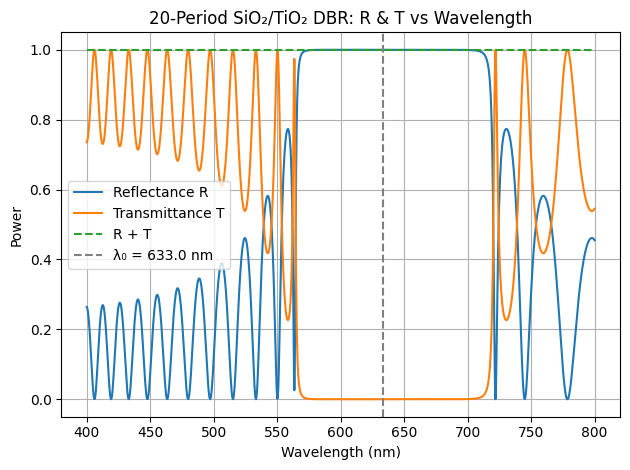

In [ ]:
plt.figure()
plt.plot(wavelengths*1e9, Rs, label='Reflectance R')
plt.plot(wavelengths*1e9, Ts, label='Transmittance T')
plt.plot(wavelengths*1e9, Rs+Ts, '--', label='R + T')
plt.axvline(lambda0*1e9,
            linestyle='--', color='gray',
            label=f'λ₀ = {lambda0*1e9:.1f} nm')  # Design wavelength marker
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power')
plt.title('20-Period SiO₂/TiO₂ DBR: R & T vs Wavelength')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Inference:** The 20-period $SiO₂/TiO₂$ DBR achieves near-perfect reflectance (>99%) at the design wavelength (633 nm) with a broad stopband (400–800 nm), demonstrating effective Bragg interference. Energy conservation is maintained (R + T ≈ 1), confirming a lossless system, while reduced spectral ripples compared to shorter stacks highlight improved mirror quality.

**4. 20-Period SiO₂/TiO₂ DBR: Reflectance & Transmittance vs Free-Space Wavenumber (Air–DBR–Air)**



In [1]:
import numpy as np
import matplotlib.pyplot as plt

Defines the target wavelength and material indices for a 20-period dielectric stack.

In [2]:
# Design wavelength and refractive indices
lambda0   = 633e-9     # design wavelength (m)
n_air     = 1.0        # surrounding medium: air
n_silica  = 1.45       # SiO₂ (low-index material)
n_titania = 2.07       # TiO₂ (high-index material)
periods   = 20         # number of SiO₂/TiO₂ bilayers

Compute each layer’s physical thickness. Its optical thickness = $λ₀⁄4$.

In [3]:
# Quarter-wave layer thicknesses
d_silica  = lambda0 / (4 * n_silica) # SiO₂ layer thickness (m)
d_titania = lambda0 / (4 * n_titania) # TiO₂ layer thickness (m)

Build two parallel lists $(ns, ds)$ describing refractive-index and thickness at each interface, including the semi-infinite air layers at front and back.

In [18]:
ns = [n_air] + [val for _ in range(periods) for val in (n_silica, n_titania)] + [n_air]
ds = [0] + [val for _ in range(periods) for val in (d_silica, d_titania)] + [0]

Create the 2×2 transfer matrix for one dielectric layer, linking fields across it.

In [17]:
def layer_matrix(n, d, wavelength):
    k0    = 2 * np.pi / wavelength # Free-space wavenumber
    delta = n * k0 * d       # Phase accumulation in layer
    Y     = n

    # Return characteristic matrix for TE polarization
    return np.array([
        [np.cos(delta),         1j * np.sin(delta) / Y],
        [1j * Y * np.sin(delta), np.cos(delta)]
    ])

Multiply together each layer’s matrix (excluding the semi-infinite ends) to get the stack’s overall matrix.

In [16]:
def stack_matrix(ns, ds, wavelength):
    M = np.eye(2, dtype=complex) # Initialize with identity matrix

     # Multiply layer matrices (skip first and last air layers)
    for n, d in zip(ns[1:-1], ds[1:-1]):
        M = M @ layer_matrix(n, d, wavelength)
    return M

From the full stack matrix, extract amplitude reflection/transmission coefficients and convert them to power reflectance R and transmittance T.

In [15]:
def reflect_transmit(ns, ds, wavelength):
    Y0 = ns[0]  # Incident medium admittance (air)
    Ys = ns[-1]  # Substrate medium admittance (air)

    # Get total transfer matrix
    M  = stack_matrix(ns, ds, wavelength)
    M11, M12, M21, M22 = M.flatten()

    # Calculate reflection coefficient (r) and transmission coefficient (t)
    num =  Y0*M11 + Y0*Ys*M12 - M21 - Ys*M22
    den =  Y0*M11 + Y0*Ys*M12 + M21 + Ys*M22
    r   = num / den
    t   = (2 * Y0) / den

    # Convert to power ratios
    R   = np.abs(r)**2  # Reflectance
    T   = np.abs(t)**2 * (Ys / Y0) # Transmittance
    return R, T


Evaluate R and T over the 400–800 nm range (1000 points), then convert wavelengths to free-space wavenumber for plotting.

In [14]:
# Generate wavelength range (400-800 nm) in meters
wavelengths = np.linspace(400e-9, 800e-9, 1000)

# Calculate R and T for all wavelengths
Rs, Ts      = zip(*(reflect_transmit(ns, ds, wl) for wl in wavelengths))
Rs, Ts      = np.array(Rs), np.array(Ts)

# Convert wavelengths to free-space wavenumbers (k₀ = 2π/λ)
k0s       = 2 * np.pi / wavelengths
k0_design = 2 * np.pi / lambda0


Display $R(k₀)$ and $T(k₀)$ curves, with a vertical line marking the design wavenumber.

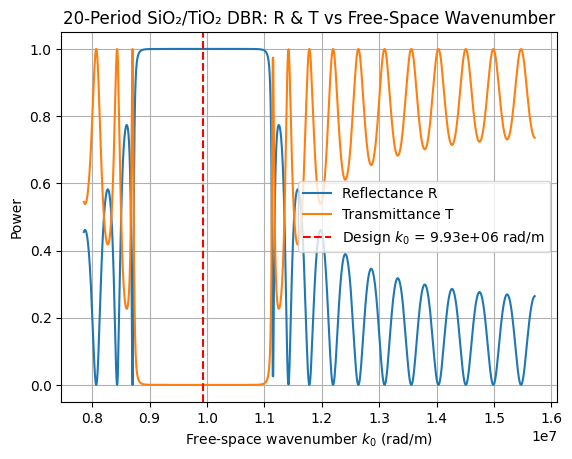

In [20]:
plt.figure()
plt.plot(k0s, Rs, label='Reflectance R')
plt.plot(k0s, Ts, label='Transmittance T')

# Add vertical line at design wavenumber
plt.axvline(k0_design,
            linestyle='--',
            color='red',
            label=f"Design $k_0$ = {k0_design:.2e} rad/m")

# Formatting
plt.xlabel('Free-space wavenumber $k_0$ (rad/m)')
plt.ylabel('Power')
plt.title('20-Period SiO₂/TiO₂ DBR: R & T vs Free-Space Wavenumber')
plt.legend()
plt.grid(True)
plt.show()


**Inference:** The 20-period $SiO₂/TiO₂$ DBR reaches nearly 100% reflectance and negligible transmittance, defining the center of its stop-band. The high refractive-index contrast yields a broad spectral range around this point where reflectance exceeds 90%, sustaining strong reflection over many nanometers. Outside this region, the quarter-wave interference no longer holds, reflectance falls steeply, and transmittance correspondingly rises toward unity.